<a href="https://www.kaggle.com/code/aaliyahraderberg/box-office-analysis-2020-2024?scriptVersionId=166184610" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Data Analysis and Visualization of Domestic Box Office Box from 2020 - 2024
### source: www.boxofficemojo.com

In [1]:
#import libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd

# Set maximum number of displayed columns to None
pd.set_option('display.max_columns', None)

# Your remaining libraries
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from PIL import Image
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.tools as tls

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, KFold

from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Data Loading and Exploration

In [2]:
import os

# List files in directory
file_list = os.listdir('/kaggle/input')
print(file_list)

# Read train and test CSV files
train = pd.read_csv('../input/box-office/train.csv')
test = pd.read_csv('../input/box-office/test.csv')


['box-office']


Text(0.5, 1.0, 'Distribution of log of revenue')

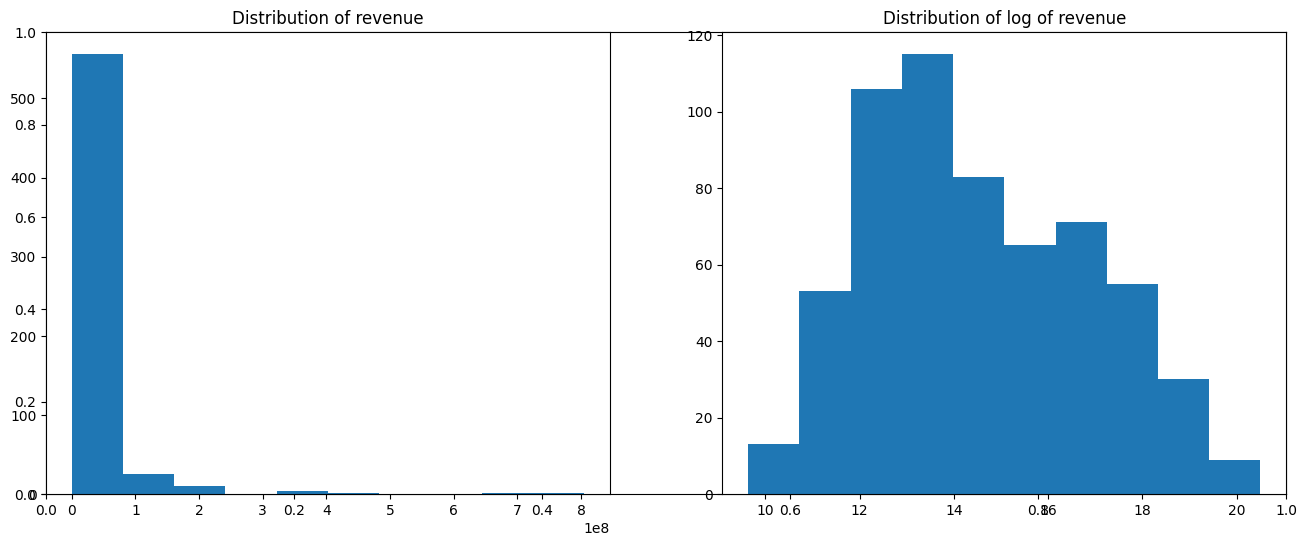

In [3]:
# Distribution of target values
fig, ax = plt.subplots(figsize=(16, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(train['Gross'])
ax1.set_title('Distribution of revenue')

ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(np.log1p(train['Gross']))
ax2.set_title('Distribution of log of revenue')

# Explicitly remove overlapping axes
#ax1.remove()



## Relationship between Film Revenue and Opening revenue

Text(0.5, 1.0, 'Distribution of log of Opening revenue')

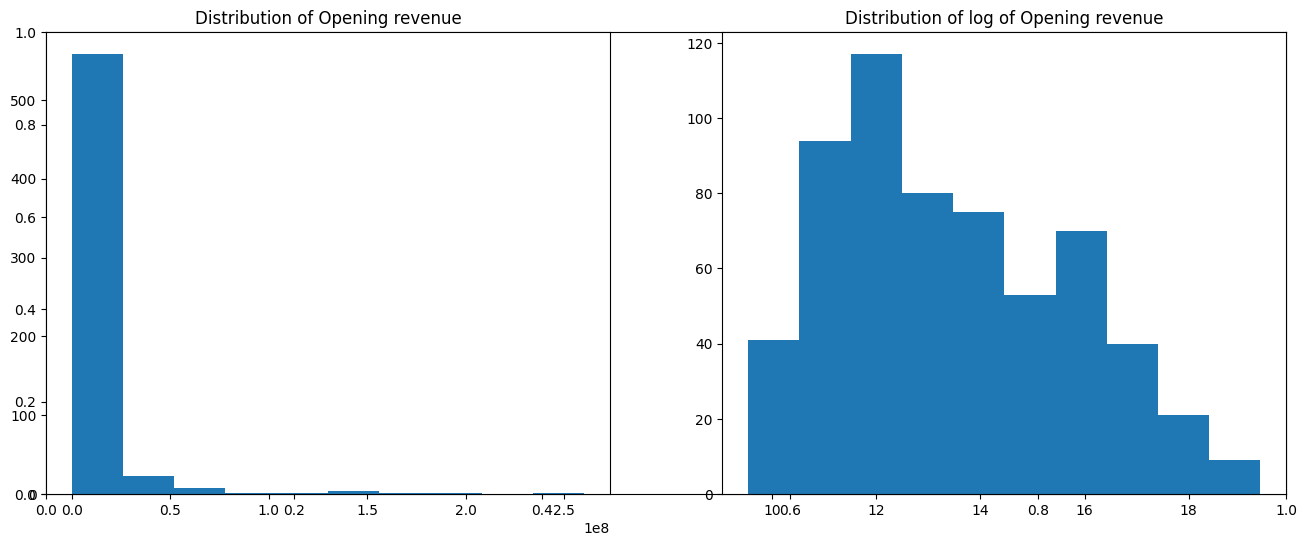

In [4]:
fig, ax = plt.subplots(figsize=(16, 6))
ax1 = fig.add_subplot(1, 2, 1)
ax1.hist(train['Opening'])
ax1.set_title('Distribution of Opening revenue')
ax2 = fig.add_subplot(1, 2, 2)
ax2.hist(np.log1p(train['Opening']))
ax2.set_title('Distribution of log of Opening revenue')

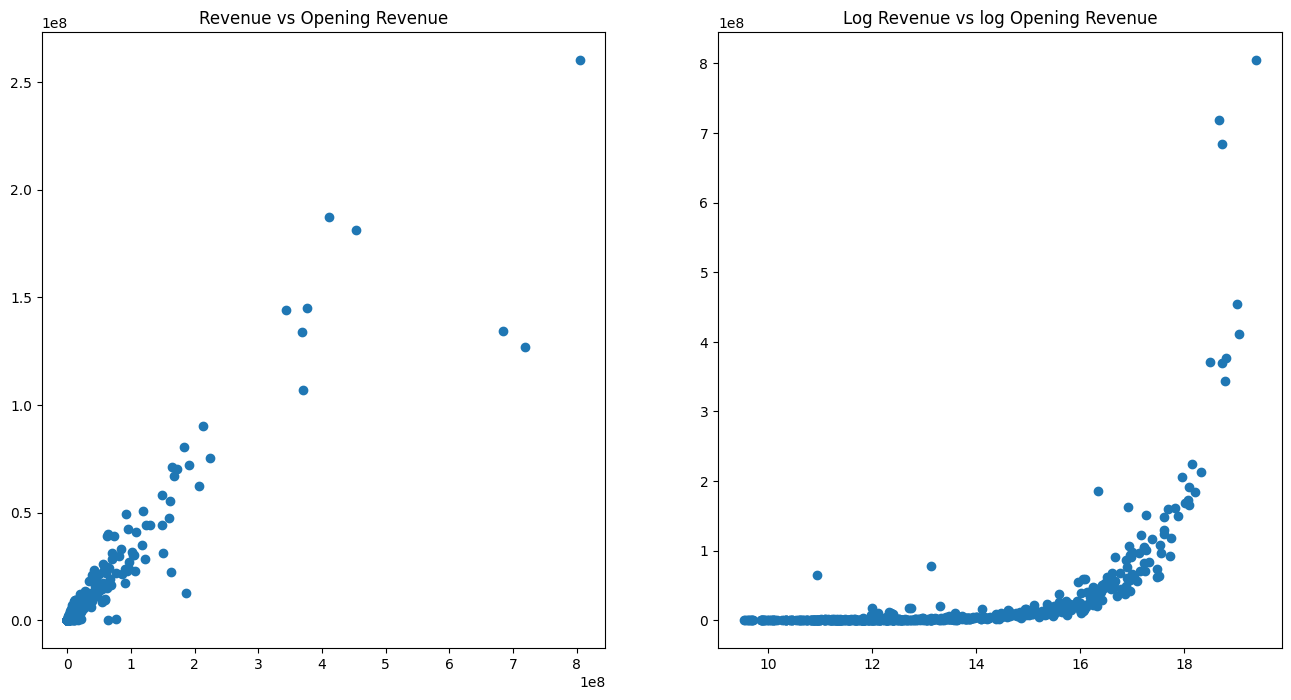

In [5]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.scatter(train['Gross'], train['Opening'])
plt.title('Revenue vs Opening Revenue');
plt.subplot(1, 2, 2)
plt.scatter(np.log1p(train['Opening']), train['Gross'])
plt.title('Log Revenue vs log Opening Revenue');

## Frequent Words in Movie Titles

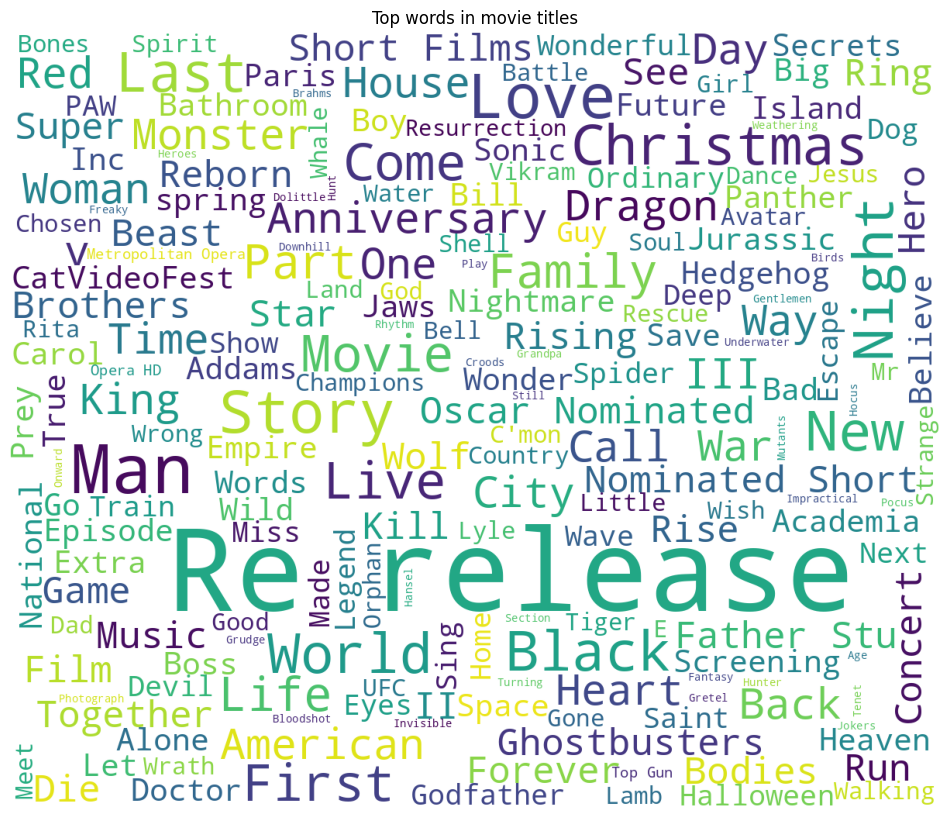

In [6]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['Release'].values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in movie titles')
plt.axis("off")
plt.show()

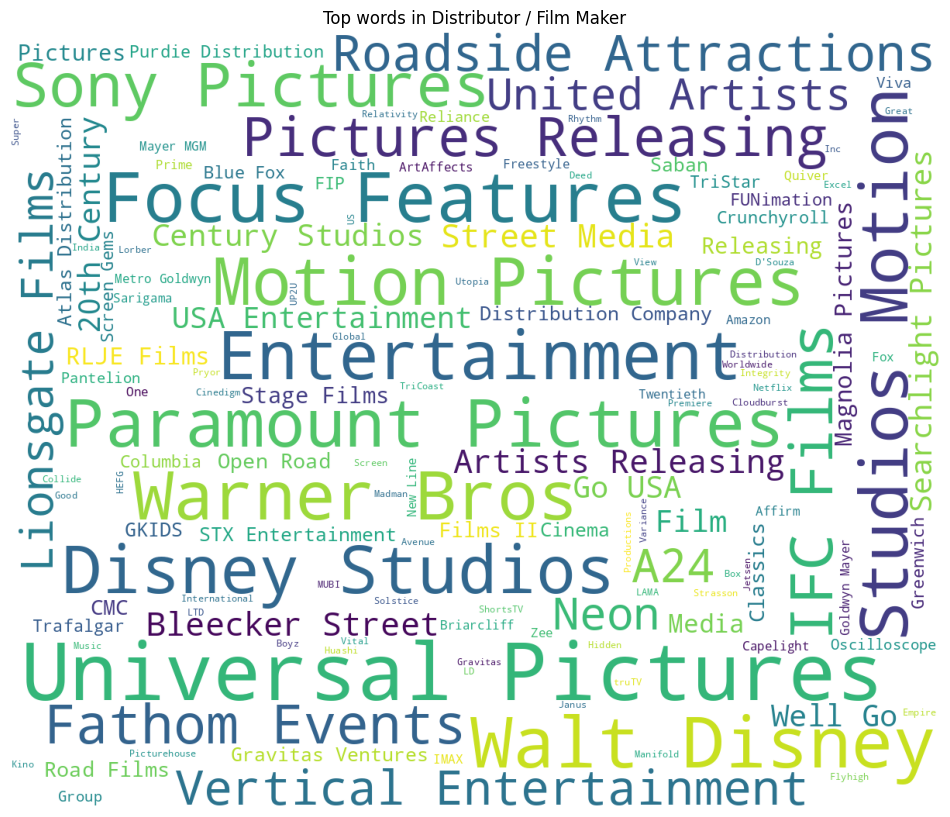

In [7]:
plt.figure(figsize = (12, 12))
text = ' '.join(train['Distributor'].fillna('').values)
wordcloud = WordCloud(max_font_size=None, background_color='white', width=1200, height=1000).generate(text)
plt.imshow(wordcloud)
plt.title('Top words in Distributor / Film Maker')
plt.axis("off")
plt.show()

## Does movies Titles or names Impact Gross Revenue?

In [8]:
import eli5
from sklearn.linear_model import LinearRegression

vectorizer = TfidfVectorizer(
            sublinear_tf=True,
            analyzer='word',
            token_pattern=r'\w{1,}',
            ngram_range=(1, 2),
            min_df=5)

release_text = vectorizer.fit_transform(train['Release'].fillna(''))
linreg = LinearRegression()
linreg.fit(release_text, train['Gross'])
eli5.show_weights(linreg, vec=vectorizer, top=20, feature_filter=lambda x: x != '<BIAS>')


2024-03-09 15:07:01.814947: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 15:07:01.815065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 15:07:01.967470: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
# Check the number of rows in the 'train' dataframe
print("Number of rows in train dataframe:", len(train))

# Print the target value at index 1000 if it exists
if len(train) > 1000:
    print('Target value:', train['Gross'][1000])
    eli5.show_prediction(linreg, doc=train['Release'].values[1000], vec=vectorizer)
else:
    print("Index 1000 is out of range for the 'train' dataframe.")

Number of rows in train dataframe: 600
Index 1000 is out of range for the 'train' dataframe.


In [10]:
print('Target value:', train['Gross'][559])
eli5.show_prediction(linreg, doc=train['Release'].values[559], vec=vectorizer)

Target value: 17348945


## Analyzing Movie Release Dates


In [11]:
test.loc[test['ReleaseDate'].isnull() == False, 'ReleaseDate'].head()

0      5/6/2022
1    11/11/2022
2     6/10/2022
3      7/8/2022
4    12/16/2022
Name: ReleaseDate, dtype: object

### Creating Features Based on Release Date

In [12]:
train['ReleaseDate'] = pd.to_datetime(train['ReleaseDate'])
test['ReleaseDate'] = pd.to_datetime(test['ReleaseDate'])

In [13]:
def process_date(df):
    date_parts = ['year', 'month', 'weekday', 'day', 'quarter']
    for part in date_parts:
        part_col = 'ReleaseDate' + '_' + part
        df[part_col] = getattr(df['ReleaseDate'].dt, part).astype(int)
    
    # Extract ISO week number
    df['ReleaseDate_weekofyear'] = df['ReleaseDate'].dt.isocalendar().week.astype(int)
    
    return df

train = process_date(train)
test = process_date(test)


## Using Plotly to Visualize the Number of Movies Per Year

In [14]:
d1 = train['ReleaseDate_year'].value_counts().sort_index()
d2 = test['ReleaseDate_year'].value_counts().sort_index()

In [15]:
#2024 dataset is incomplete as it is ongoing


data = [go.Scatter(x=d1.index, y=d1.values, name='train'),
        go.Scatter(x=d2.index, y=d2.values, name='test')]

layout = go.Layout(dict(title = 'Number of Movies per Year',
                       xaxis = dict(title = 'Year'),
                       yaxis = dict(title = 'Count'),
                        ), legend = dict(orientation='v'))
py.iplot(dict(data=data, layout=layout))

## Number of Movies and Revenue Per Year

In [16]:
d1 = train['ReleaseDate_year'].value_counts().sort_index()
d2 = train.groupby(['ReleaseDate_year'])['Gross'].sum()

data = [go.Scatter(x=d1.index, y=d1.values, name='movie count'),
        go.Scatter(x=d2.index, y=d2.values, name='total revenue', yaxis='y2')] 

layout = go.Layout(dict(title = 'Number of Movies and Total Revenue per Year',
                       xaxis = dict(title = 'Year'),
                       yaxis = dict(title = 'Count'),
                       yaxis2 = dict(title='Total Revenue', overlaying='y', side='right')), 
                   legend = dict(orientation='v'))
py.iplot(dict(data=data, layout=layout))

In [17]:
d1 = train['ReleaseDate_year'].value_counts().sort_index()
d2 = train.groupby(['ReleaseDate_year'])['Gross'].sum()

data = [go.Scatter(x=d1.index, y=d1.values, name='movie count'),
        go.Scatter(x=d2.index, y=d2.values, name='mean revenue', yaxis='y2')]

layout = go.Layout(dict(title = 'Number of Movies and Average Revenue per Year',
                       xaxis = dict(title = 'Year'),
                       yaxis = dict(title = 'Count'),
                       yaxis2 = dict(title='Avg Revenue', overlaying='y', side='right')), 
                   legend = dict(orientation='v'))
py.iplot(dict(data=data, layout=layout))

## Do Release Days Impact Revenue?

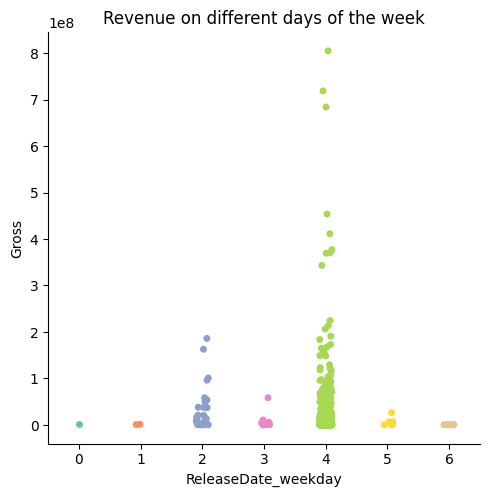

In [18]:
# Replace infinite values with NaN in 'Gross' column
train.replace([np.inf, -np.inf], np.nan, inplace=True)

# Plotting with color
sns.catplot(x='ReleaseDate_weekday', y='Gross', hue='ReleaseDate_weekday', data=train, palette='Set2')
plt.title('Revenue on different days of the week')
plt.show()

#Tuesdays and Thursdays best box office revenue
